In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

from sklearn import set_config; set_config(display='diagram')

# Importamos el dataset limpio y lematizado

In [3]:
df_lem = pd.read_csv('../../cyberbullying/data/lem_all_df.csv')
df_lem.head()

,text,target
0,this one can make an analogy in mathematical t...,0.0
1,clarification for you and zundark s right i sh...,0.0
2,elected or electoral jhk,0.0
3,this is such a fun entry devotchka i once had ...,0.0
4,please relate the ozone hole to increases in c...,0.0


In [4]:
df_lem.shape

(227442, 2)

## Distribución del dataset

In [5]:
def plot_dist(df):
    plt.figure(figsize = (7,7))
    sorted_counts = df['target'].value_counts()
    plt.pie(sorted_counts, labels = ['not bullying', 'bullying'], startangle = 90, counterclock = False,
            wedgeprops = {'width' : 0.6}, autopct='%1.1f%%', pctdistance = 0.7,
            textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
            colors = sns.color_palette("Paired")[7:])
    plt.text(x = -0.35, y = 0, s = f'Total comments: {df.shape[0]}')
    plt.title('Distribution of Comments in the Dataset', fontsize = 16);

Tomamos una muestra del dataset para investigar

In [6]:
percentage_used = 1
df_sample = df_lem.sample(frac=percentage_used, random_state=0)

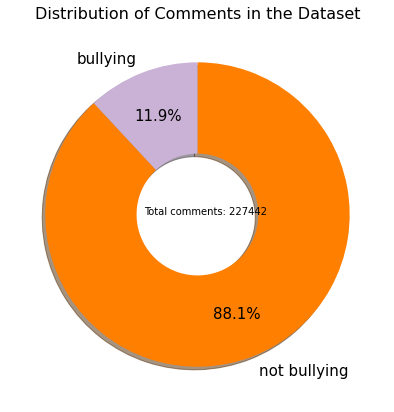

In [7]:
plot_dist(df_sample)

# Holdout

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_sample['text'], df_sample['target'], test_size=0.3, random_state=0)

In [9]:
X_train = pd.DataFrame(data=X_train, columns=['text'])
X_test = pd.DataFrame(data=X_test, columns=['text'])

## Balanceamos el dataset (paso descartado)

In [10]:
def balance_df(X, y, ratio=0.3):
    df = pd.DataFrame({'text': X, 'target': y})
    df_class_0 = df[df['target'] == 0]
    df_class_1 = df[df['target'] == 1]
    df_class_1_len = df_class_1.shape[0]
    
    df_class_0_new = df_class_0.sample(int(df_class_1_len * (1-ratio)/ratio))
    df_new = pd.concat([df_class_0_new, df_class_1]).sample(frac=1).reset_index(drop=True)
    
    X = df_new['text']
    y = df_new['target']

    return X, y

#X_train, y_train = balance_df(X_train, y_train, ratio=0.1)
# no lo usamos

# Definimos métricas y funciones

In [11]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
scorer = make_scorer(f1_score)

In [12]:
def scores(cv_results):
    score_results = {'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
    for key in score_results.keys():
        if key == 'time':
            score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
        else:
            score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
    return score_results

In [13]:
def conf_mx_all(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)
    
    TN = cm[0,0]
    TP = cm[1,1]
    FN = cm[1,0]
    FP = cm[0,1]
    
    recall = np.round_(TP/(TP+FN),3)
    precision = np.round_(TP/(TP+FP),3)
    accuracy = np.round_((TP+TN)/(TP+TN+FP+FN),3)
    F1= np.round((2*precision*recall)/(precision+recall), 3)
    
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {F1}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot();
    
    return recall, precision, accuracy, F1

In [14]:
def get_best_model(model, type_):
    name = model[type_]
    params = model[f'{type_} Params']
    return eval(f'{name}(**{params})')

Definimos la pipeline para evaluar los distintos algoritmos

In [15]:
def pipeline(vectorizer_list, learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    def list_params(new_class):
        name = new_class.__class__.__name__
        default_class = eval(name + '()').get_params()
        new_class = new_class.get_params()

        new_dict = {}

        for key in new_class.keys():
            if new_class[key] != default_class[key]:
                new_dict[key] = new_class[key]
        return new_dict
    
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for vectorizer in vectorizer_list:
        
        X_train_vec = vectorizer.fit_transform(X_train['text'])
        X_test_vec = vectorizer.transform(X_test['text'])
        
    
        for learner in learner_list:

            # Store the vectorizer name and params:
            results['Vectorizer'] = vectorizer.__class__.__name__
            results['Vectorizer Params'] = list_params(vectorizer)

            # Store the learner name and params:
            results['Algorithm'] = learner.__class__.__name__
            results['Algorithm Params'] = list_params(learner)

            # Fit the learner:
            start = time() # Get start time
            learner = learner.fit(X_train_vec, y_train)
            end = time() # Get end time

            # Store the training time
            results['Training Time'] = round(end - start, 2)

            start = time() # Get start time
            predictions_test = learner.predict(X_test_vec)
            predictions_train = learner.predict(X_train_vec)
            end = time() # Get end time

            # Store the prediction time
            results['Prediction Time'] = round(end - start, 2)

            # Compute the F1 Score on Test Set
            results['f1'] = round(f1_score(y_test, predictions_test), 4)

            # Compute the Recall on Test Set
            results['recall'] = round(recall_score(y_test, predictions_test), 4)
            
            # Compute the Precision on Test Set
            results['precision'] = round(precision_score(y_test, predictions_test), 4)
            
            # Compute the Accuracy on Test Set
            results['accuracy'] = round(accuracy_score(y_test, predictions_test), 4)

            final_results.append(results.copy())
            
    # Return a dataframe of the results
    return final_results

## Instanciamos los distintos vectorizadores y clasificadores

In [16]:
# make a list of vectorizers
vectorizers = [TfidfVectorizer(max_features=10000),
]

# make a list of models
models = [LinearSVC(C=0.8),
          LinearSVC(C=0.9),
          LinearSVC(C=1.0),
          LinearSVC(C=1.1),
]

In [17]:
%%time

re = pipeline(vectorizers, models, X_train, y_train, X_test, y_test)
results = pd.DataFrame(re)

results = results.sort_values(by = 'f1', ascending = False).reset_index(drop = True)

best_model = results

results

CPU times: user 14.1 s, sys: 143 ms, total: 14.3 s
Wall time: 14.3 s


,Vectorizer,Vectorizer Params,Algorithm,Algorithm Params,Training Time,Prediction Time,f1,recall,precision,accuracy
0,TfidfVectorizer,{'max_features': 10000},LinearSVC,{'C': 1.1},1.39,0.02,0.6266,0.5354,0.7551,0.9232
1,TfidfVectorizer,{'max_features': 10000},LinearSVC,{'C': 0.9},1.30,0.01,0.6255,0.5328,0.7571,0.9232
2,TfidfVectorizer,{'max_features': 10000},LinearSVC,{},1.48,0.01,0.6255,0.5338,0.7551,0.9231
3,TfidfVectorizer,{'max_features': 10000},LinearSVC,{'C': 0.8},1.28,0.02,0.6250,0.5314,0.7587,0.9233


In [18]:
vectorizer = TfidfVectorizer()

X_train_vec = vectorizer.fit_transform(X_train['text'])
X_test_vec = vectorizer.transform(X_test['text'])

In [19]:
X_train_vec

<159209x182284 sparse matrix of type '<class 'numpy.float64'>'
	with 6597474 stored elements in Compressed Sparse Row format>

In [20]:
%%time
# Linear SVC
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

model = LinearSVC(max_iter=10000, dual=True)

search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
search.fit(X_train_vec, y_train)

CPU times: user 929 ms, sys: 208 ms, total: 1.14 s
Wall time: 20.7 s


GridSearchCV(cv=5, estimator=LinearSVC(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.25, 0.5, 0.75, 1, 1.2]})

In [21]:
best_estimator = search.best_estimator_
best_estimator

LinearSVC(C=0.25, max_iter=10000)

In [22]:
y_pred = best_estimator.predict(X_test_vec)

Recall: 0.522
Precision: 0.779
Accuracy: 0.925
F1-score: 0.625


(0.522, 0.779, 0.925, 0.625)

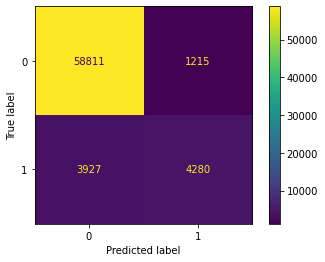

In [23]:
conf_mx_all(y_test, y_pred)

# Tuneo de hiperparametros

## class_weight

In [24]:
def tune_threshold(C=1):
    score_results = {'class_weight': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
    
    def scores2(cv_results, class_weight):
        score_results = {'class_weight': None, 'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
        for key in score_results.keys():
            if key == 'class_weight':
                score_results[key] = class_weight
            elif key == 'time':
                score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
            else:
                score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
        return score_results
    
    for class_weight in np.arange(0.05, 0.5, 0.05):
        #print(class_weight)
        
        cv_results = cross_validate(LinearSVC(C=C, class_weight={0:class_weight, 1:1-class_weight}),
                                    X_train_vec, y_train, cv=5, n_jobs=-1,
                                    scoring=['accuracy', 'precision', 'recall', 'f1'])

        score_results_new = scores2(cv_results, class_weight)
        
        for key in score_results.keys():
            score_results[key].append(score_results_new[key])
            
        
    plt.figure(figsize=(12,6))
        
    plt.plot(score_results['class_weight'], score_results['recall'], c='r', label='recall')
    plt.plot(score_results['class_weight'], score_results['precision'], c='b', label='precision')    
    plt.plot(score_results['class_weight'], score_results['f1'], c='g', label='f1')
    plt.xlabel('class weight')
    plt.ylabel('score')
    plt.legend()
    plt.grid(alpha=0.3)
        
    #return score_results

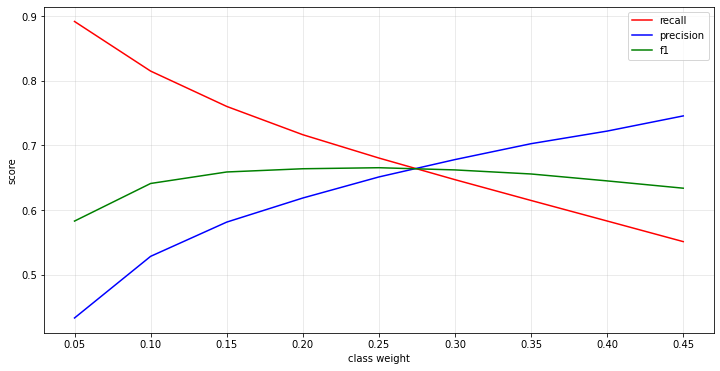

In [25]:
tune_threshold(C=1)

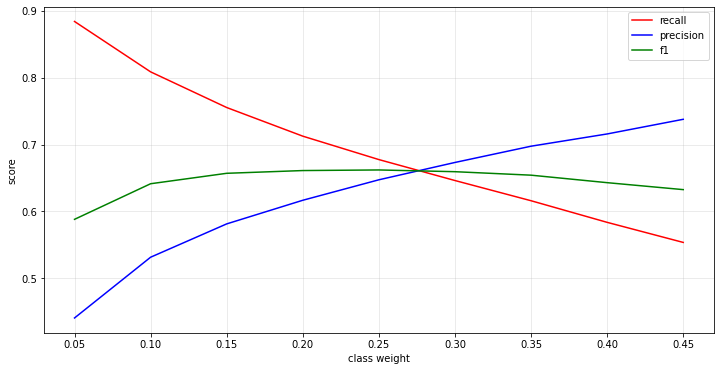

In [26]:
tune_threshold(C=1.2)

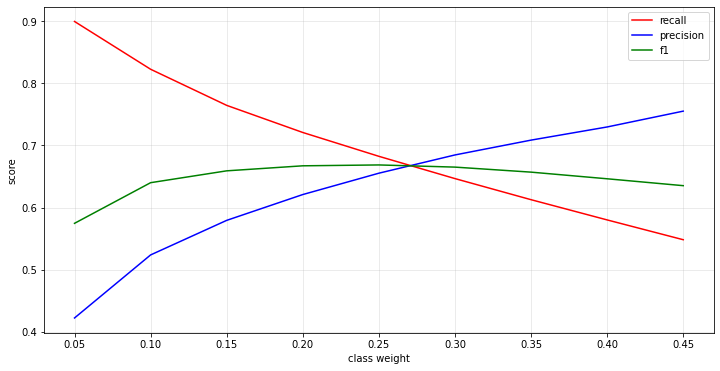

In [27]:
tune_threshold(C=0.8)

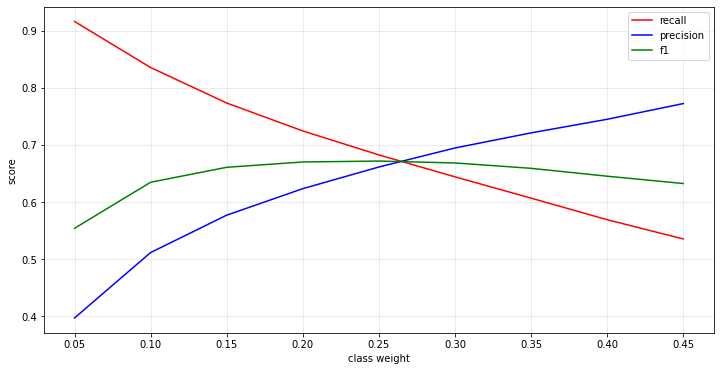

In [28]:
tune_threshold(C=0.5)

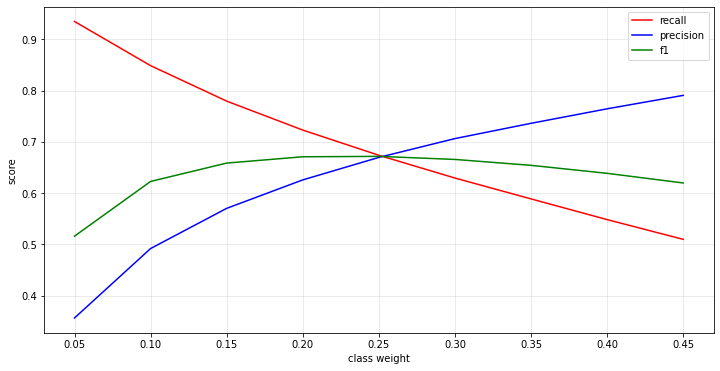

In [29]:
tune_threshold(C=0.25)

## otros

In [30]:
min_df = 3
max_df = 1.0
max_features = None

vectorizer = TfidfVectorizer(min_df=min_df,
                             max_df=max_df,
                             max_features=max_features)

In [31]:
C = 1
penalty = 'l1'
loss = 'squared_hinge'
dual = False
class_weight_0 = 0.20
class_weight = {0:class_weight_0, 1:1-class_weight_0}

model = LinearSVC(C=C,
                  class_weight=class_weight,
                  penalty=penalty,
                  loss=loss,
                  dual=dual)

In [32]:
preprocessing = make_column_transformer(
    (make_pipeline(vectorizer), 'text')
)

pipe = make_pipeline(
    preprocessing,
    model
)

pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(min_df=3))]),
                                                  'text')])),
                ('linearsvc',
                 LinearSVC(C=1, class_weight={0: 0.2, 1: 0.8}, dual=False,
                           penalty='l1'))])

In [33]:
cv_results = cross_validate(pipe, X_train, y_train, cv=5, n_jobs=-1, scoring=scoring)

In [34]:
scores(cv_results)

{'accuracy': 0.9158,
 'precision': 0.621,
 'recall': 0.7486,
 'f1': 0.6788,
 'time': 14.1}

In [35]:
pipe.fit(X_train, y_train);

In [36]:
y_pred = pipe.predict(X_test)

In [37]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(min_df=3))]),
                                                  'text')])),
                ('linearsvc',
                 LinearSVC(C=1, class_weight={0: 0.2, 1: 0.8}, dual=False,
                           penalty='l1'))])

Recall: 0.741
Precision: 0.623
Accuracy: 0.915
F1-score: 0.677


(0.741, 0.623, 0.915, 0.677)

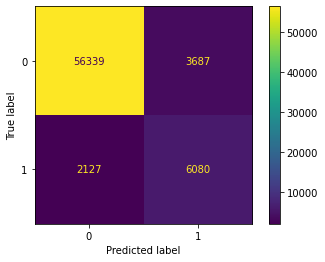

In [38]:
conf_mx_all(y_test, y_pred)

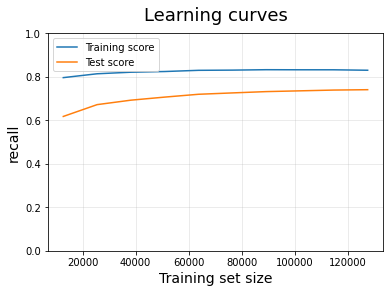

In [39]:
from sklearn.model_selection import learning_curve


train_sizes = np.linspace(.1,  1, 10)
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, X=X_train_vec, y=y_train, train_sizes=train_sizes, cv=5, scoring='recall')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('recall', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend();

In [40]:
def tune_threshold_2(C=1):
    score_results = {'class_weight': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
    
    def scores2(cv_results, class_weight):
        score_results = {'class_weight': None, 'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
        for key in score_results.keys():
            if key == 'class_weight':
                score_results[key] = class_weight
            elif key == 'time':
                score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
            else:
                score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
        return score_results
    
    for class_weight in np.arange(0.05, 0.5, 0.05):
        #print(class_weight)
        
        cv_results = cross_validate(LinearSVC(C=C, class_weight={0:class_weight, 1:1-class_weight}, penalty='l1', loss = 'squared_hinge', dual=False),
                                    X_train_vec, y_train, cv=5, n_jobs=-1,
                                    scoring=['accuracy', 'precision', 'recall', 'f1'])

        score_results_new = scores2(cv_results, class_weight)
        
        for key in score_results.keys():
            score_results[key].append(score_results_new[key])
            
        
    plt.figure(figsize=(12,6))
        
    plt.plot(score_results['class_weight'], score_results['recall'], c='r', label='recall')
    plt.plot(score_results['class_weight'], score_results['precision'], c='b', label='precision')    
    plt.plot(score_results['class_weight'], score_results['f1'], c='g', label='f1')
    plt.xlabel('class weight')
    plt.ylabel('score')
    plt.legend()
    plt.grid(alpha=0.3)
        
    #return score_results

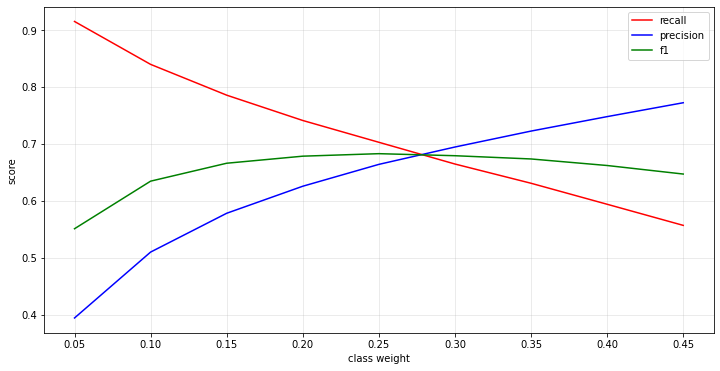

In [41]:
tune_threshold_2(C=1.0)

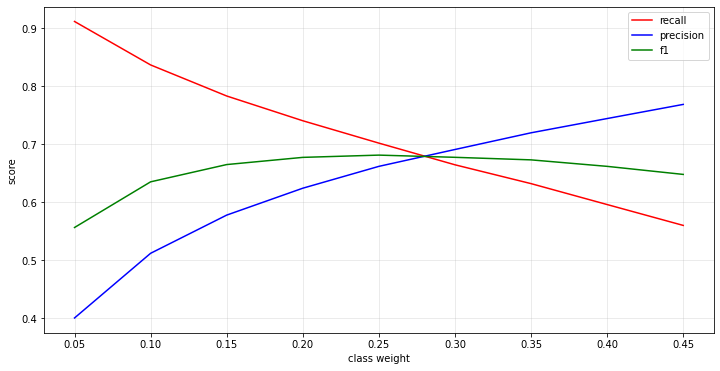

In [42]:
tune_threshold_2(C=1.1)

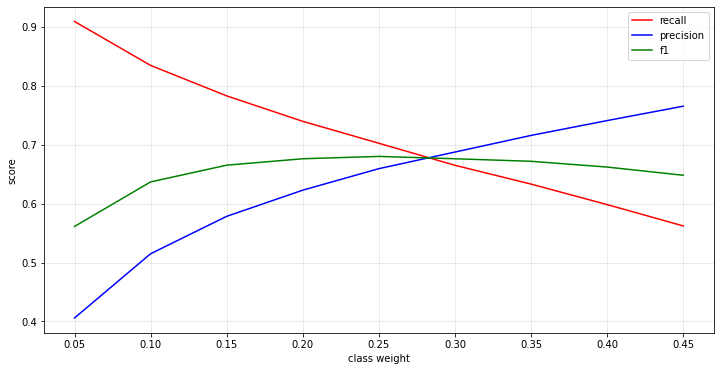

In [43]:
tune_threshold_2(C=1.2)

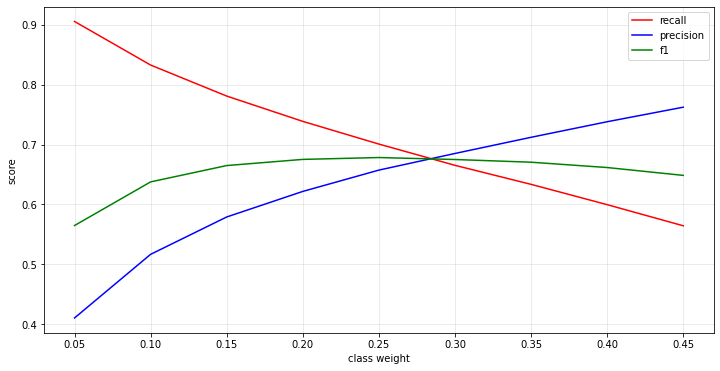

In [44]:
tune_threshold_2(C=1.3)

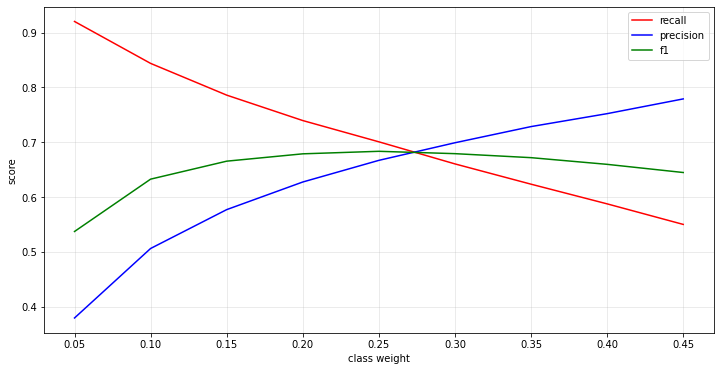

In [45]:
tune_threshold_2(C=0.8)

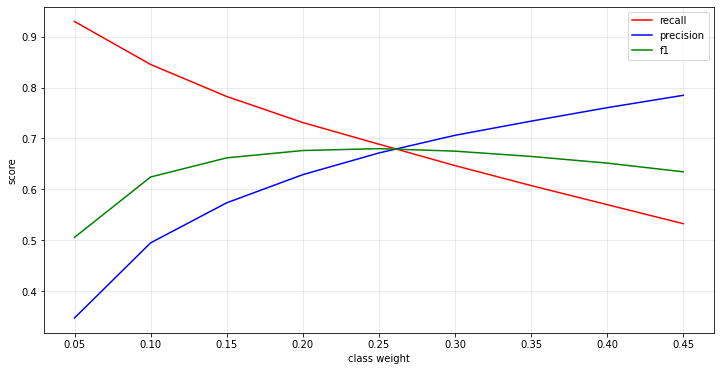

In [46]:
tune_threshold_2(C=0.5)

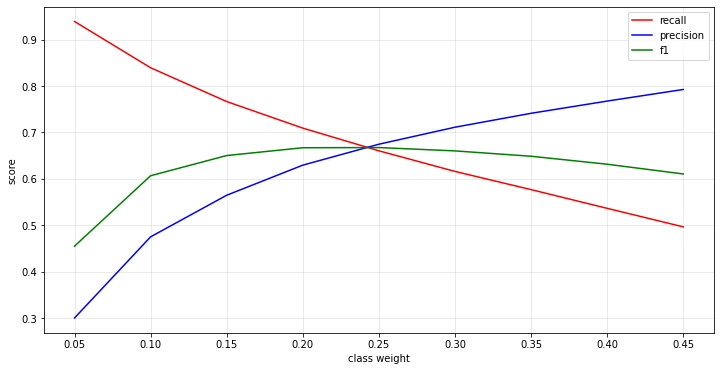

In [47]:
tune_threshold_2(C=0.25)